In [333]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels.formula.api as smf
import datetime
import requests
import io

%matplotlib inline
sns.set(
    font_scale=1,
    rc={'figure.figsize': (19, 9)})

### Задание 1

_id_ – означает покупку (в одну покупку входят все товары, купленные пользователем во время 1 похода в магазин)
<br>
_Товар_ – наименование товара
<br>
_Количество_ – число единиц купленного товара

Воспользуйтесь этими данными и выясните, какие пары товаров пользователи чаще всего покупают вместе.
<br>
По сути, вам необходимо найти паттерны покупок, что позволит оптимизировать размещение продуктов в магазине,
<br>
для удобства пользователей и увеличения выручки.

In [334]:
url = "https://raw.githubusercontent.com/oksana-suvorova/my-projects/main/test1_completed.csv" 
# ссылка на файл с исходными данными на гитхабе
download = requests.get(url).content
data = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [335]:
data.head(5)

,id,Товар,Количество
0,17119,Лимон,1.1
1,17119,Лимон оранжевый,0.7
2,17119,Лук-порей,10.0
3,17119,Лук репчатый,2.5
4,17119,Малина свежая,1.0


In [336]:
data.dtypes

id              int64
Товар          object
Количество    float64
dtype: object

In [337]:
data.isna().sum()
# пропущенных значений в таблице нет

id            0
Товар         0
Количество    0
dtype: int64

In [338]:
data.id = data.id.astype(str)
# смена типа данных необходима для того, чтобы сделать в дальнейшем сцепки

In [339]:
# мержим таблицу сама с собой для того, чтобы получить пары товаров в корзине
# применяем левое соединение, чтобы создать всевозможные пары в корзине потребителя (однако будут повторы в таблице)
goods = data.merge(data, how='left', on='id')

In [340]:
goods = goods[['id', 'Товар_x', 'Товар_y']]

In [341]:
# создаем ключи из id_x_y и id_y_x 
# это необходимо для поиска повторяющихся строк при комбинации корзины с той же самой корзиной
# например, 17119_Лимон_Лимон оранжевый и 17119_Лимон оранжевый_Лимон - это одна и та же пара, ее нужно будет удалить
# чтобы пары товаров не задвоились (это может привести к ошибке при подсчете пар)
goods['id_x_y'] = goods.id + '_' + goods.Товар_x + '_' + goods.Товар_y
goods['id_y_x'] = goods.id + '_' + goods.Товар_y + '_' + goods.Товар_x

In [342]:
# сортируем данные по id,Товар_x,Товар_y по возрастанию (для корректной работы функции)
goods = goods.sort_values(['id', 'Товар_x', 'Товар_y'])

In [343]:
goods.head(5)

,id,Товар_x,Товар_y,id_x_y,id_y_x
663100,100029,Кунжут белый,Кунжут белый,100029_Кунжут белый_Кунжут белый,100029_Кунжут белый_Кунжут белый
663098,100029,Кунжут белый,Пастернак корень,100029_Кунжут белый_Пастернак корень,100029_Пастернак корень_Кунжут белый
663099,100029,Кунжут белый,"Сахар-песок, 5кг","100029_Кунжут белый_Сахар-песок, 5кг","100029_Сахар-песок, 5кг_Кунжут белый"
663101,100029,Кунжут белый,Черника свежая,100029_Кунжут белый_Черника свежая,100029_Черника свежая_Кунжут белый
663092,100029,Пастернак корень,Кунжут белый,100029_Пастернак корень_Кунжут белый,100029_Кунжут белый_Пастернак корень


In [344]:
# создаем функцию, которая будет просматривать сцепку id_y_x и искать такое же значение в столбце со сцепкой id_x_у, 
# таким образом мы поставим True на те строки, где товар или повторяется (например, Лимон Лимон), или на те строки, где 
# товары уже встречались в строках раньше, но были поменяны местами 
# (например, Лимон Лимон оранжевый и Лимон оранжевый Лимон)
def repeat(id, x_y, y_x):
    repeats = []  # новый список, в него будем класть True и False
    m = pd.Series(id.value_counts()).reset_index().sort_values('index')
    # создание таблицы с id покупки и кол-вом строк с этим id в таблице
    s = 0
    ss = 0
    for j in range(0, len(m)):  # идем по id
        for i in range(ss, ss + m.id[j]):  # идем по столбцу у_x конкретного id
            repeats.append(y_x.iloc[i] in x_y.iloc[ss:i + 1].tolist())
            # если элемент из столбца y_x есть в кусочке столбца x_y с начала и до строки i, то в repeats добавляем true, 
            # иначе false
            s = s + 1
        ss = s
    return repeats

In [345]:
goods['repeats'] = repeat(goods['id'], goods['id_x_y'], goods['id_y_x'])

In [346]:
patt = goods.query('repeats == False'). \
             groupby(['Товар_x', 'Товар_y']). \
             agg({'id': 'count'}). \
             sort_values('id', ascending=False). \
             head(5)
# паттерны покупок

In [347]:
patt 
# пары товаров, которые пользователи чаще всего покупают вместе

,,id
Товар_x,Товар_y,
Огурцы Луховицкие,Укроп,431
Петрушка,Укроп,408
Арбуз,Огурцы Луховицкие,345
Кабачки,Огурцы Луховицкие,326
Кинза,Укроп,303


In [348]:
# Таким образом, неоходимо разместить товары:
# Огурцы Луховицкие - Укроп
# Петрушка - Укроп
# Арбуз - Огурцы Луховицкие
# Кабачки - Огурцы Луховицкие
# Кинза - Укроп
# рядом дург с другом для удобства пользователей и увеличения выручки.

In [349]:
# Также привожу решение данной задачи более легким способом, также таким образом проверим решение, полученное выше

In [350]:
# мержим таблицу сама с собой для того, чтобы получить пары товаров в корзине
# применяем левое соединение, чтобы создать всевозможные пары в корзине потребителя (однако будут повторы в таблице)
goods_2 = data.merge(data, how='left', on='id')

In [351]:
goods_2 = goods_2[['id', 'Товар_x', 'Товар_y']]

In [352]:
goods_2['col'] = goods_2.Товар_x < goods_2.Товар_y

In [353]:
goods_2.head(5)

,id,Товар_x,Товар_y,col
0,17119,Лимон,Лимон,False
1,17119,Лимон,Лимон оранжевый,True
2,17119,Лимон,Лук-порей,True
3,17119,Лимон,Лук репчатый,True
4,17119,Лимон,Малина свежая,True


In [354]:
patt = goods_2.query('col == True'). \
             groupby(['Товар_x', 'Товар_y']). \
             agg({'id': 'count'}). \
             sort_values('id', ascending=False). \
             head(5)
# паттерны покупок

In [355]:
patt
# ответы аналогичны

,,id
Товар_x,Товар_y,
Огурцы Луховицкие,Укроп,431
Петрушка,Укроп,408
Арбуз,Огурцы Луховицкие,345
Кабачки,Огурцы Луховицкие,326
Кинза,Укроп,303


### Задание 2

К вам поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям.
<br>
Постройте (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с
<br>
2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%

In [356]:
url = "https://raw.githubusercontent.com/oksana-suvorova/my-projects/main/test2_completed.csv" 
# ссылка на файл с исходными данными на гитхабе
download = requests.get(url).content
orders = pd.read_csv(io.StringIO(download.decode('utf-8')))

In [357]:
orders.head()

,Дата,Число заказов
0,2020-01-05,650
1,2020-01-12,837
2,2020-01-19,1020
3,2020-01-26,1176
4,2020-02-02,1489


In [358]:
orders = orders.rename(columns={'Дата': 'date', 'Число заказов': 'orders'})

In [359]:
orders.dtypes

date      object
orders     int64
dtype: object

In [360]:
orders.date = pd.to_datetime(orders.date)

In [361]:
orders.shape

(14, 2)

14 значений - для прогнозирования временного ряда этого немного, сезонность по месяцам или неделям рассчитать по этим
<br>
данным не получится (желательно иметь несколько лет для расчета сезонности (например, 3 года))
<br>
но можно построить линейную регрессию для приблизительного прогноза

In [362]:
# так как прогноз продаж нужно строить по базовой линии (то есть по продажам, не учитывая акции),
# то на неделе с 2020-02-02 по 2020-02-09 необходимо рассчитать реальную базовую линию
orders.loc[(orders.date == '2020-02-02'), 'orders'] = orders.orders / 1.07

2020-02-02 - это воскресенье, то есть или мы рассматриваем данные иностранной фирмы, где неделя начинается
<br>
с воскресенья и тогда именно эту неделю - 2020-02-02 нужно делить на 1,07,
<br>
или кол-во заказов недели записывается последним днем недели, и тогда нужно 2020-02-09 делить на 1,07
<br>
я полагаю, что первый вариант корректен и поэтому неделю корректирую 2020-02-02
<br>
однако при работе лучше это уточнить:)

In [363]:
orders.head(6)

,date,orders
0,2020-01-05,650.000000
1,2020-01-12,837.000000
2,2020-01-19,1020.000000
3,2020-01-26,1176.000000
4,2020-02-02,1391.588785
5,2020-02-09,1823.000000


In [364]:
fig = px.line(orders, x="date", y="orders")
fig.show()
# растущий тренд

In [365]:
orders['num'] = np.arange(len(orders)) + 1

In [366]:
orders.head()

,date,orders,num
0,2020-01-05,650.000000,1
1,2020-01-12,837.000000,2
2,2020-01-19,1020.000000,3
3,2020-01-26,1176.000000,4
4,2020-02-02,1391.588785,5


In [367]:
# строим линейную регрессию МНК
results = smf.ols('orders ~ num', orders).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 orders   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     649.2
Date:                Sat, 06 Nov 2021   Prob (F-statistic):           8.12e-12
Time:                        19:14:46   Log-Likelihood:                -88.667
No. Observations:                  14   AIC:                             181.3
Df Residuals:                      12   BIC:                             182.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    256.0027     83.074      3.082      0.0

In [368]:
# Adj. R-squared высокий

In [369]:
# получившаяся модель orders = 256.0027 + 248.5957 * num
intercept = smf.ols('orders ~ num', orders).fit().params[0]
paramnum = smf.ols('orders ~ num', orders).fit().params[1]

In [370]:
# формула для расчета прогноза на 3 месяца вперед
for i in range(15, 28):
    orders.loc[i] = [pd.to_datetime('2020-04-05') + datetime.timedelta(days=(i - 14) * 7), intercept + paramnum * i, i]

In [371]:
# для интереса посчитаем точность прогноза и BIAS

In [372]:
orders['forecast'] = intercept + paramnum * orders.num

In [373]:
orders['BIAS, %'] = (1 - orders.orders / orders.forecast).mul(100).round(1)
# отрицательный BIAS - недопрогнозировали, положительный - перепрогнозировали
# BIAS почти на всех наблюдениях не выходит за пределы +-10%, это хороший показатель

In [374]:
orders['FA, %'] = (1 - np.absolute(orders.forecast - orders.orders) / orders.orders).mul(100).round(1)
# точность прогноза показывает насколько мы точно в своих прогнозах в сравнении с фактом
# точность прогноза почти на всех неделях более 90%, что тоже очень хорошо

In [375]:
orders.head(5)

,date,orders,num,forecast,"BIAS, %","FA, %"
0,2020-01-05,650.000000,1,504.598398,-28.8,77.6
1,2020-01-12,837.000000,2,753.194126,-11.1,90.0
2,2020-01-19,1020.000000,3,1001.789853,-1.8,98.2
3,2020-01-26,1176.000000,4,1250.385581,5.9,93.7
4,2020-02-02,1391.588785,5,1498.981308,7.2,92.3


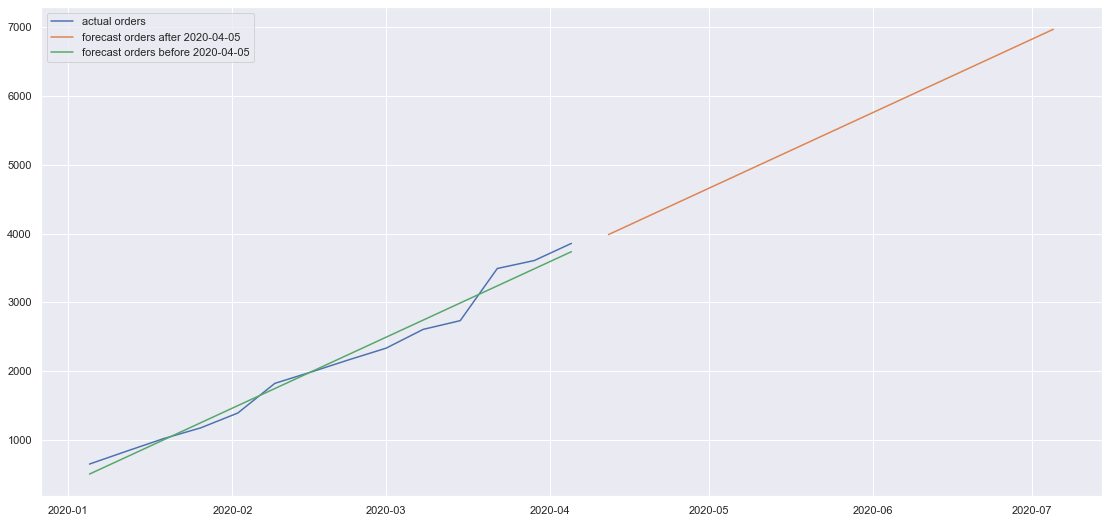

In [376]:
plt.plot(orders.query('date < "2020-04-12"').date, orders.query('date < "2020-04-12"').orders, label='actual orders')
plt.plot(orders.query('date > "2020-04-05"').date, orders.query('date > "2020-04-05"').orders, label='forecast orders after 2020-04-05')
plt.plot(orders.query('date < "2020-04-12"').date, orders.query('date < "2020-04-12"').forecast, label='forecast orders before 2020-04-05')
plt.legend()

Видим, что прогнозные значения довольно близки к фактическим данным
<br>

При расчете прогноза с помощью линейной регрессии наш прогноз стремится вверх по тренду
<br>
однако стоит понимать, что линейная взаимосвязь не всегда может быть линейной. И, возможно, в какой-то момент 
<br>
рост линии тренда будет постепенно потухать (например, рынок насытится товаром).
<br>

В дальнейшем хотелось бы иметь больше данных для анализа. 
<br>
Желательно несколько лет, чтобы корректно рассчитать сезонность.
<br>
Имея больше наблюдений, можно воспользоваться библиотеками для прогнозирования временных рядов, 
<br>
например, библиотекой Facebook Prophet, которая учитывает сезонность, тренд, аномальные дни.

### Задание 3

Написание запроса

В базе данных вашей компании присутствуют следующие таблицы

_city_

city_id – id города, где проходит акция
<br>
client_city_id – id города, где находится покупатель
<br>
city – город
<br>
client_city – город, где находится покупатель

_client_

client_id – id покупателя
<br>
client_city_id – id города, где находится покупатель
<br>
birth_date – дата рождения покупателя
<br>
registration – дата регистрации покупателя
<br>

_promotion_

promotion_id – id акции
<br>
category_id – id категории
<br>
promotion_name – акция
<br>
category_name – категория
<br>
partner_id – id партнёра
<br>
partner_name – партнёр
<br>

_purchase_

purchase_id – id покупки
<br>
partner_id – id партнёра
<br>
client_id – id покупателя
<br>
city_id – id города
<br>
promotion_id – id акции
<br>
category_id – id категории
<br>
purchase_date – дата покупки
<br>
price – цена за единицу товара
<br>
quantity – число проданных единиц
<br>
status – статус покупки

Вам нужно написать запрос, чтобы получить такую таблицу

purchase_date – дата покупки
<br>
purchase_id – id покупки
<br>
client_id – id покупателя
<br>
client_age – возраст покупателя
<br>
client_registration_age – как долго человек пользуется вашими магазинами
<br>
client_category – содержит new или old, если это первая или последующая покупка соответственно
<br>
promotion_name – акция
<br>
category_name – категория
<br>
partner_name – партнёр
<br>
client_city – город, где находится покупатель
<br>
city – город
<br>
revenue – сумма выручки
<br>
quantity – число проданных единиц

При этом в таблице должны присутствовать только значения, где в поле status стоит значение 1, и только те, где purchase_date находится в диапазоне от 01.05.2020 до 01.08.2020

In [377]:
import pandahouse as ph

In [378]:
con_project_variant_2 = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'project_variant_2',
                      'user':'student', 
                      'password':'dpo_python_2020'}

In [379]:
query = """
SELECT 
    purchase.purchase_date AS purchase_date, --дата покупки
    CAST(purchase.purchase_id AS integer) AS purchase_id, --id покупки
    CAST(purchase.client_id AS integer) AS client_id, -- id покупателя
    CAST ((toYear(purchase.purchase_date) - toYear(client.birth_date) - CASE
        WHEN (
                toMonth(purchase.purchase_date) < toMonth(client.birth_date) 
                or 
                (
                toMonth(purchase.purchase_date) = toMonth(client.birth_date) and toDayOfMonth(purchase.purchase_date) < toDayOfMonth(client.birth_date)
                )
              ) THEN 1
        ELSE 0
        END) AS integer) AS client_age, --количество полных лет покупателя на момент покупки
    CAST ((toYear(purchase.purchase_date)-toYear(client.registration) - CASE
        WHEN (
                toMonth(purchase.purchase_date) < toMonth(client.registration) 
                or 
                (
                toMonth(purchase.purchase_date) = toMonth(client.registration) and toDayOfMonth(purchase.purchase_date) < toDayOfMonth(client.registration)
                )
              ) THEN 1
        ELSE 0
        END) AS integer) AS client_registration_age, --как долго человек пользуется вашими магазинами на момент покупки
    CASE
        WHEN client_min_day_reg_pur.min_day_reg_pur = DATEDIFF('day', client.registration, purchase.purchase_date) THEN 'new'
        ELSE 'old'
        END AS client_category, --содержит new или old, если это первая или последующая покупка соответственно (во всем дата сете, не только в промежуток от 01.05.2020 до 01.08.2020, то есть если первая покупка была до 01.05.2020, то на всех строках будет old. Это кажется логичным, так как если было бы new, то можно было бы подумать, что именно в этот период клиент вервые что-то заказал, а это неверно)
    promotion.promotion_name AS promotion_name, --акция
    promotion.category_name AS category_name, --категория
    promotion.partner_name AS partner_name, --партнёр
    client_city.client_city AS client_city, --город, где находится покупатель
    dist_city.city AS city, --город, где проходит акция
    CAST(purchase.price * purchase.quantity AS integer) AS revenue, --сумма выручки
    CAST(purchase.quantity AS integer) as quantity -- число проданных единиц

FROM
    project_variant_2.purchase as purchase

LEFT JOIN
    project_variant_2.client as client
ON
    purchase.client_id = client.client_id
    
LEFT JOIN
    (
        SELECT DISTINCT
            client.client_id,
            client.registration,
            MIN(purchase.purchase_date) AS min_pur_date,
            MIN(DATEDIFF('day', client.registration, purchase.purchase_date)) AS min_day_reg_pur
        FROM
            project_variant_2.client as client
        JOIN
            project_variant_2.purchase as purchase
        ON
            client.client_id = purchase.client_id
        GROUP BY
            client.client_id,
            client.registration
        ORDER BY
            client.client_id,
            client.registration
    ) AS client_min_day_reg_pur
ON
    purchase.client_id = client_min_day_reg_pur.client_id
    
LEFT JOIN
    project_variant_2.promotion as promotion
ON
    purchase.promotion_id = promotion.promotion_id
    AND purchase.category_id = promotion.category_id
    AND purchase.partner_id = promotion.partner_id

LEFT JOIN
    (
        SELECT DISTINCT
            client.client_id,
            city.client_city 
        FROM
            project_variant_2.client as client
        JOIN
            project_variant_2.city as city
        ON
            client.client_city_id = city.client_city_id
        ORDER BY
            client.client_id
    ) AS client_city
ON
    purchase.client_id = client_city.client_id
    
LEFT JOIN
    (
        SELECT DISTINCT
            city.city_id,
            city.city 
        FROM
            project_variant_2.city as city
        ORDER BY
            city.city_id
    ) AS dist_city
ON
    purchase.city_id = dist_city.city_id

WHERE
    purchase.status = 1
    AND purchase.purchase_date >= '2020-05-01'
    AND purchase.purchase_date <= '2020-08-01'

ORDER BY
    purchase.client_id,
    purchase.purchase_date
"""

In [380]:
df = ph.read_clickhouse(query, connection=con_project_variant_2)

In [381]:
df.head(10)

,purchase_date,purchase_id,client_id,client_age,client_registration_age,client_category,promotion_name,category_name,partner_name,client_city,city,revenue,quantity
0,2020-07-20,3002,1,24,0,new,,,,Вена,Новгород,660,3
1,2020-07-24,3626,1,24,0,old,,,,Вена,Ярославль,2280,8
2,2020-07-26,918,1,24,0,old,,,,Вена,Минск,615,3
3,2020-05-15,7362,2,21,1,old,,,,Щучинщина,Вена,180,9
4,2020-05-21,6702,2,21,1,old,,,,Щучинщина,Минск,465,3
5,2020-05-29,7349,2,21,1,old,,,,Щучинщина,Новгород,2080,8
6,2020-06-08,6111,2,21,1,old,campaign_3,Овощи,Всем партнёрам партнёр,Щучинщина,Минск,360,1
7,2020-07-16,8155,2,21,1,old,,,,Щучинщина,Минск,2655,9
8,2020-05-24,1351,3,25,0,old,,,,Ярославль,Новгород,950,2
9,2020-05-27,793,4,24,0,old,,,,Казань,Киев,2520,8
